In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal

In [72]:
# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

# 平方根平均二乗誤差（Root mean square error）を計算
def rms_error(dataset, f):
    err = 0.0
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        err += 0.5 * (y - f(x))**2
    return np.sqrt(2 * err / len(dataset))

# 最小二乗法で解を求める
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    return (f, ws)

def plotRmsError():
    # トレーニングセットとテストセットでの誤差の変化を表示
    df = DataFrame(columns=['Training set','Test set'])
    for m in range(0,10):   # 多項式の次数
        f, ws = resolve(train_set, m)
        train_error = rms_error(train_set, f)
        test_error = rms_error(test_set, f)
        df = df.append(
                Series([train_error, test_error],
                    index=['Training set','Test set']),
                ignore_index=True)
    df.plot(title='RMS Error', style=['-','--'], grid=True, ylim=(0,0.9))
    plt.show()
    return

In [82]:
# Main
#------------#
# Parameters #
#------------#
N=10            # サンプルを取得する位置 x の個数
M=[0,1,3,9]     # 多項式の次数


def RMS(N,M):
# if __name__ == '__main__':
    df_ws = DataFrame()

    # 多項式近似の曲線を求めて表示
    fig = plt.figure()
    for c, m in enumerate(M):
        f, ws = resolve(train_set, m)
        df_ws = df_ws.append(Series(ws,name="M=%d" % m))

        subplot = fig.add_subplot(2,2,c+1)
        subplot.set_xlim(-0.05,1.05)
        subplot.set_ylim(-1.5,1.5)
        subplot.set_title("M=%d" % m)

        # トレーニングセットを表示
        subplot.scatter(train_set.x, train_set.y, marker='o', color='blue')

        # 真の曲線を表示
        linex = np.linspace(0,1,101)
        liney = np.sin(2*np.pi*linex)
        subplot.plot(linex, liney, color='green', linestyle='--')

        # 多項式近似の曲線を表示
        linex = np.linspace(0,1,101)
        liney = f(linex)
        label = "E(RMS)=%.2f" % rms_error(train_set, f)
        subplot.plot(linex, liney, color='red', label=label)
        subplot.legend(loc=1)

    # 係数の値を表示
    print "Table of the coefficients"
    print df_ws.transpose()

Table of the coefficients
        M=0       M=1        M=3            M=9
0 -0.116671  0.674128  -0.086812      -0.092643
1       NaN -1.581597  11.883190    -132.647960
2       NaN       NaN -36.551733    3096.512173
3       NaN       NaN  24.801627  -26242.956987
4       NaN       NaN        NaN  114351.908216
5       NaN       NaN        NaN -287661.568866
6       NaN       NaN        NaN  433655.971172
7       NaN       NaN        NaN -386428.310710
8       NaN       NaN        NaN  187608.183119
9       NaN       NaN        NaN  -38247.092328


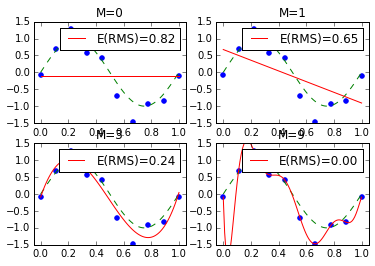

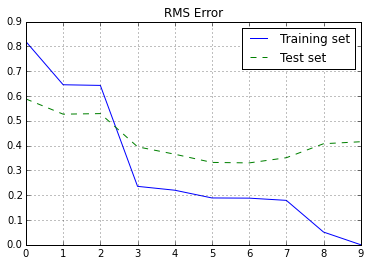

In [83]:
N = 10
train_set = create_dataset(N)
test_set = create_dataset(N)
df_ws = DataFrame()
RMS(N, M)
plotRmsError()

# 2.2 オーバーフィッティングの検出

## 2.2.1 トレーニングセットとテストセット

### 最適な次数とは？
* トレーニングセットだけではわからない。なぜなら正解のモデルがわからないから
* 特徴が多ければ多いほど、視覚的にわかりにくくなる
    
### どうするか？
* 新しいデータから予測値と観測値を比較する
* ...というのは難しいので、利用可能なデータをトレーニング用とテスト用にわける。

## 2.2.2 テストセットによる検証結果

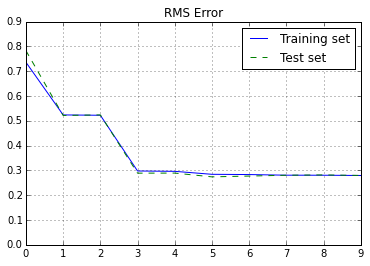

In [75]:
plotRmsError()

### 結果
* トレーニングセットにおける誤差は次数が大きくなれば０に近づく
* だが**テストセットでは、その限りではない！**
    * 次数4移行に変化はない -> 予測力は高まらない
    * **モデルの汎化能力**の限界　
    * トレーニングセットに特化しすぎたチューニング -> **オーバーフィッティング**
    
## 2.2.3 クロスバリデーションによる汎化能力の検証
### データを分ける際にしてはいけないこと
* トレーニングセット内のデータをテストセットに混ぜること

### クロスバリデーション
* 利用可能なデータを幾つかのグループに分ける（今回の場合、各次数をグルーピング）
* その１つのグループをテストセットとして用いた検証を行う(今回の場合、各次数の誤差を検証)
* 上記の検証を全グループで行い、検証結果を総合して判断する（今回の場合、次数を決定）

### 2.2.4 データ数によるオーバーフィッティングの変化
* データ数が少ない場合, 取得したデータが偶然にもってる特徴が目立ちがち
* データ数が多いほど本質的な特徴をとらえるので、オーバーフィッティングしにくい


N > M野必要

Table of the coefficients
        M=0       M=1        M=3            M=9
0 -0.028501  0.866720  -0.184624      -0.430108
1       NaN -1.790442  12.112580      42.887747
2       NaN       NaN -36.342164    -734.831819
3       NaN       NaN  24.849276    6348.027074
4       NaN       NaN        NaN  -29360.814635
5       NaN       NaN        NaN   77902.749138
6       NaN       NaN        NaN -122949.764673
7       NaN       NaN        NaN  114144.690381
8       NaN       NaN        NaN  -57541.243632
9       NaN       NaN        NaN   12149.041852


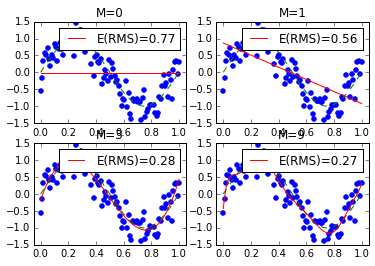

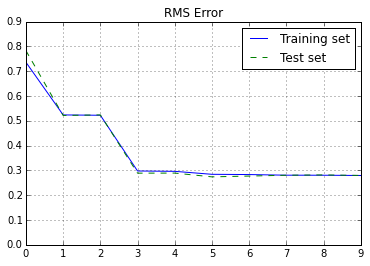

In [71]:
N = 100
train_set = create_dataset(N)
test_set = create_dataset(N)
df_ws = DataFrame()

RMS(N, M)
plotRmsError()